# Second attempt - barebones code without functions defined

*training optdigits dataset*

In [1]:
using Plots
using LinearAlgebra
using Statistics
using Random
using Printf # helps with printing up to certain digit

# including functions for loading dataset
include("./ffnnModule.jl")
using .mnistLoader

In [76]:
# activation functions
function relu(x::AbstractVector)
    return max.(0f0,x)
end

# matrix relu
function relu_derivative(x::AbstractMatrix)
    rows, cols = size(x)
    answer = Array{Float64}(undef, rows, cols)
    for i in 1:rows
        for j in 1:cols
            if x[i, j] < 0
                answer[i, j] = 0.0
            else
                answer[i, j] = 1.0
            end
        end
    end
    return answer
end

# vector relu
function relu_derivative(x::AbstractVector)
    answer = []
    for val in x
        if val < 0
            push!(answer,Float64(0.))
        else
            push!(answer,Float64(1.))
        end
    end
    return answer
end

function softmax(x::AbstractVector)
    # subtracting max value prevents overflow
    exp_x = exp.(x .- maximum(x))
    return exp_x ./ sum(exp_x)
end


function softmax_derivative(x::AbstractArray)
    x = softmax(x)
    return x .* (1 .- x)
end

function cross_entropy_loss(output, label)
    return - dot(label, log.(output)) + dot((1 .- label), log.(1 .- output))
end

function cross_entropy_loss_derivative(output, label)
    - label ./ output + (1 .- label) ./ (1 .- output)
end

function normalize_matrix_to_one(matrix::Matrix{Float64})
    # Compute the sum of absolute values of all elements in the matrix
    sum_abs = sum(abs.(matrix))
    
    if sum_abs == 0
        return matrix  # Return the original matrix if sum of absolute values is zero to avoid division by zero
    else
        return matrix / sum_abs  # Normalize each element in the matrix
    end
end

function normalize_matrix_to_one(matrix::Vector{Float64})
    # Compute the sum of absolute values of all elements in the matrix
    sum_abs = sum(abs.(matrix))
    
    if sum_abs == 0
        return matrix  # Return the original matrix if sum of absolute values is zero to avoid division by zero
    else
        return matrix / sum_abs  # Normalize each element in the matrix
    end
end

# adam optimization (for single layer)
function update_with_ADAM(weight_grads::Matrix{Float64}, bias_grads::Vector{Float64}, vw::Matrix{Float64}, sw::Matrix{Float64}, vb::Vector{Float64}, sb::Vector{Float64}, t::Float64, beta1::Float64 = 0.9, beta2::Float64 = 0.999)
    #=
    l - depth of a network
    v, s - preinitialized matrix-like hyperparameters
    t - number of times update was performed in current Epoch
    beta1, beta2 - predefined float hyperparameters
    =#
    vw_corrected = zeros(size(vw))
    sw_corrected = zeros(size(sw))

    vw_corrected = zeros(size(vb))
    sw_corrected = zeros(size(sb))
        
    @. vw = beta1 * vw + (1 - beta1) * weight_grads
    @. vb = beta1 * vb + (1 - beta1) * bias_grads

    vw_corrected = vw ./ (1 - beta1 ^ t)
    vb_corrected = vb ./ (1 - beta1 ^ t)

    @. sw = beta2 * sw + (1 - beta2) * sqrt(weight_grads)
    @. sb = beta2 * sb + (1 - beta2) * sqrt(bias_grads)

    sw_corrected = sw ./ (1 - beta2 ^ t)
    sb_corrected = sb ./ (1 - beta2 ^ t)

    weight_gradient_adam = vw ./ sqrt.(sw .+ eps(Float64))
    bias_gradient_adam = vb_corrected ./ sqrt.(sb_corrected .+ eps(Float64))
    
    return weight_gradient_adam, bias_gradient_adam, vw, vb, sw, sb
end

pi_sqrt = sqrt(pi)

1.7724538509055159

In [3]:
# Optdigits dataset loaders 
batch_size = 64

train_file_path = "./mnist_red/optdigits.tra"
test_file_path = "./mnist_red/optdigits.tes"

feature_batches, label_batches = optdigits_data_processing(train_file_path, batch_size=batch_size)
test_features, test_labels = optdigits_data_processing(test_file_path, do_batch=false)
train_features, train_labels = optdigits_data_processing(train_file_path, do_batch=false)

([0.0 0.0625 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.3125 0.0; 0.0 0.0 … 0.0 0.0], [1.0 0.0 … 0.0 0.0; 1.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0])

# single iteration

In [77]:
# hyperparameters
learning_rate = 0.01

# initializing layers (uniform distribution [-1,1] ; bias normal distribution normalized)
W1 = randn(Float64, 128, 64) .* sqrt(2/64)
B1 = fill(0.01, 128)
activ1 = relu
activ_der1 = relu_derivative

W2 = randn(Float64, 64, 128) .* sqrt(2/128)
B2 = fill(0.01, 64)
activ2 = relu
activ_der2 = relu_derivative

W3 = randn(Float64, 10, 64) .* sqrt(2/64)
B3 = fill(0.01, 10)
activ3 = softmax
activ_der3 = softmax_derivative

feature = feature_batches[1][2,:] 
label = label_batches[1][2,:]

# forward pass
z1 = W1 * feature + B1
a1 = activ1(z1) 

z2 = W2 * a1 + B2
a2 = activ2(z2)

z3 = W3 * a2
output = activ3(z3)

# loss function
loss = cross_entropy_loss(output, label)
loss_derivative = cross_entropy_loss_derivative(output, label)

# backpropagation_pass
delta_3 = activ_der3(loss_derivative)
delta_2 = activ_der2(transpose(W3) * delta_3)
delta_1 = activ_der1(transpose(W2) * delta_2)

grad3 = delta_3 * transpose(a2)
grad2 = delta_2 * transpose(a1)
grad1 = delta_1 * transpose(feature)

    # bias derivative of cost function equals delta * 1
grad_bias3 = delta_3
grad_bias2 = delta_2
grad_bias1 = delta_1

# updating weights (simplest case)
W3 -= (learning_rate * grad3)
B3 -= (learning_rate * grad_bias3)

W2 -= (learning_rate * grad2)
B2 -= (learning_rate * grad_bias2)

W1 -= (learning_rate * grad1)
B1 -= (learning_rate * grad_bias1)


128-element Vector{Float64}:
 0.01
 0.0
 0.0
 0.0
 0.01
 0.0
 0.0
 0.01
 0.01
 0.0
 ⋮
 0.01
 0.01
 0.0
 0.01
 0.0
 0.0
 0.0
 0.01
 0.0

# Looping through dataset (simple mean-gradient optimization)

In [108]:
# initializing layers with He rules
W1 = randn(Float64, 128, 64) .* sqrt(2/64)
B1 = fill(0.01, 128)
activ1 = relu
activ_der1 = relu_derivative

W2 = randn(Float64, 64, 128) .* sqrt(2/128)
B2 = fill(0.01, 64)
activ2 = relu
activ_der2 = relu_derivative

W3 = randn(Float64, 10, 64) .* sqrt(2/64)
B3 = fill(0.01, 10)
activ3 = softmax
activ_der3 = softmax_derivative

# vectors for plotting
costs = []
accuracies = []
train_accuracies = []

Any[]

## Full training loop

In [112]:
# hyperparameters
learning_rate = 0.01
number_of_epochs = 100


# training loop
for epoch in 1:number_of_epochs

    # randomizing batches for each epoch to prevent overfitting
    feature_batches, label_batches = optdigits_data_processing(train_file_path, batch_size=batch_size)
    inference_accuracy = zeros(Float64, size(test_labels, 1))
    inference_accuracy_train = zeros(Float64, size(train_labels, 1))
    timestep = 1.

    # ADAM variables initialization
    vW3 = zeros(size(W3))
    vB3 = zeros(size(B3))
    sW3 = zeros(size(W3))
    sB3 = zeros(size(B3))

    vW2 = zeros(size(W2))
    vB2 = zeros(size(B2))
    sW2 = zeros(size(W2))
    sB2 = zeros(size(B2))

    vW1 = zeros(size(W1))
    vB1 = zeros(size(B1))
    sW1 = zeros(size(W1))
    sB1 = zeros(size(B1))

    # looping through minibatches
    for (feature_batch, label_batch) in zip(feature_batches, label_batches)

        mean_gradient3 = zeros(size(W3))
        mean_gradient2 = zeros(size(W2))
        mean_gradient1 = zeros(size(W1))

        mean_gradient_bias3 = zeros(size(B3))
        mean_gradient_bias2 = zeros(size(B2))
        mean_gradient_bias1 = zeros(size(B1))

        temp_costs = []

        for j in 1:batch_size
            feature = feature_batch[j, :]
            label = label_batch[j, :]
            
            # forward pass
            z1 = W1 * feature + B1
            a1 = activ1(z1) 

            z2 = W2 * a1 + B2
            a2 = activ2(z2)

            z3 = W3 * a2
            output = activ3(z3)

            # loss function
            loss = cross_entropy_loss(output, label)
            # loss_derivative = cross_entropy_loss_derivative(output, label) - very low accuracy for this particular problem
            # loss_derivative = activ3(output - label)
            loss_derivative = activ3(cross_entropy_loss_derivative(output, label))

            # backpropagation pass
            #delta_3 = activ_der3(loss_derivative)
            delta_3 = loss_derivative .* (1 .- loss_derivative)
            delta_2 = activ_der2(transpose(W3) * delta_3)
            delta_1 = activ_der1(transpose(W2) * delta_2)

            mean_gradient3 .+= delta_3 * transpose(a2)
            mean_gradient2 .+= delta_2 * transpose(a1)
            mean_gradient1 .+= delta_1 * transpose(feature)

                # bias derivative of cost function equals delta * 1
            mean_gradient_bias3 .+= delta_3
            mean_gradient_bias2 .+= delta_2
            mean_gradient_bias1 .+= delta_1

            push!(temp_costs, loss)
        end

        mean_gradient3 ./= batch_size
        mean_gradient2 ./= batch_size
        mean_gradient1 ./= batch_size

        mean_gradient_bias3 ./= batch_size
        mean_gradient_bias2 ./= batch_size
        mean_gradient_bias1 ./= batch_size

        # ADAM optimization reinitialized for each epoch (it could be good idea to test it with one initialization for whole training)
        mean_gradient3, mean_gradient_bias3, vW3, vB3, sW3, sB3 = update_with_ADAM(mean_gradient3, mean_gradient_bias3, vW3, sW3, vB3, sB3, timestep)

        mean_gradient2, mean_gradient_bias2, vW2, vB2, sW2, sB2 = update_with_ADAM(mean_gradient2, mean_gradient_bias2, vW2, sW2, vB2, sB2, timestep)

        mean_gradient1, mean_gradient_bias1, vW1, vB1, sW1, sB1 = update_with_ADAM(mean_gradient1, mean_gradient_bias1, vW1, sW1, vB1, sB1, timestep)

        timestep += 1
        # changing weights
        W3 -= (learning_rate * mean_gradient3)
        B3 -= (learning_rate * mean_gradient_bias3)

        W2 -= (learning_rate * mean_gradient2)
        B2 -= (learning_rate * mean_gradient_bias2)

        W1 -= (learning_rate * mean_gradient1)
        B1 -= (learning_rate * mean_gradient_bias1)
        
        push!(costs, sum(temp_costs)/batch_size)
    end
    # calculate predictions for test dataset
    for j in 1:size(test_labels, 1)
        feature = test_features[j,:]
        label = test_labels[j,:]
        z1 = W1 * feature + B1
        a1 = activ1(z1) 
        z2 = W2 * a1 + B2
        a2 = activ2(z2)
        z3 = W3 * a2
        output = activ3(z3)
        inference_accuracy[j] = Float64(argmax(output) == argmax(label)) 
    end
    push!(accuracies, mean(inference_accuracy))
    
    #calculate predictions for training dataset
    for j in 1:size(train_labels, 1)
        feature = train_features[j,:]
        label = train_labels[j,:]
        z1 = W1 * feature + B1
        a1 = activ1(z1) 
        z2 = W2 * a1 + B2
        a2 = activ2(z2)
        z3 = W3 * a2
        output = activ3(z3)
        inference_accuracy_train[j] = Float64(argmax(output) == argmax(label)) 
    end
    push!(train_accuracies, mean(inference_accuracy_train))
    
    println("epoch: $epoch \t accuracy: $(@sprintf("%.4f%%", 100 * accuracies[end])) \t train data accuracy: $(@sprintf("%.4f%%", 100 * train_accuracies[end]))")
end



epoch: 1 	 accuracy: 43.0718% 	 train data accuracy: 45.8279%


epoch: 2 	 accuracy: 43.5726% 	 train data accuracy: 46.3249%


epoch: 3 	 accuracy: 43.9622% 	 train data accuracy: 46.9265%


epoch: 4 	 accuracy: 44.1291% 	 train data accuracy: 47.5543%


epoch: 5 	 accuracy: 44.7412% 	 train data accuracy: 47.9466%


epoch: 6 	 accuracy: 45.0195% 	 train data accuracy: 48.3652%


epoch: 7 	 accuracy: 45.2421% 	 train data accuracy: 48.6529%


epoch: 8 	 accuracy: 45.7429% 	 train data accuracy: 49.0714%


epoch: 9 	 accuracy: 46.1881% 	 train data accuracy: 49.4115%


epoch: 10 	 accuracy: 46.8559% 	 train data accuracy: 49.7515%


epoch: 11 	 accuracy: 46.9672% 	 train data accuracy: 49.9869%


epoch: 12 	 accuracy: 47.3011% 	 train data accuracy: 50.3793%


epoch: 13 	 accuracy: 47.7462% 	 train data accuracy: 50.5885%


epoch: 14 	 accuracy: 48.0245% 	 train data accuracy: 50.8763%


epoch: 15 	 accuracy: 48.5253% 	 train data accuracy: 51.1640%


epoch: 16 	 accuracy: 48.6366% 	 train data accuracy: 51.4517%


epoch: 17 	 accuracy: 48.8036% 	 train data accuracy: 51.8179%


epoch: 18 	 accuracy: 49.0818% 	 train data accuracy: 52.0534%


epoch: 19 	 accuracy: 49.4157% 	 train data accuracy: 52.3149%


epoch: 20 	 accuracy: 49.4713% 	 train data accuracy: 52.5242%


epoch: 21 	 accuracy: 49.6939% 	 train data accuracy: 52.7073%


epoch: 22 	 accuracy: 50.0835% 	 train data accuracy: 53.1781%


epoch: 23 	 accuracy: 50.4730% 	 train data accuracy: 53.3874%


epoch: 24 	 accuracy: 50.8069% 	 train data accuracy: 53.6228%


epoch: 25 	 accuracy: 51.2521% 	 train data accuracy: 53.8059%


epoch: 26 	 accuracy: 51.3634% 	 train data accuracy: 54.1198%


epoch: 27 	 accuracy: 51.5860% 	 train data accuracy: 54.3291%


epoch: 28 	 accuracy: 51.6973% 	 train data accuracy: 54.5645%


epoch: 29 	 accuracy: 51.6973% 	 train data accuracy: 54.9045%


epoch: 30 	 accuracy: 52.0312% 	 train data accuracy: 55.1399%


epoch: 31 	 accuracy: 52.4207% 	 train data accuracy: 55.2446%


epoch: 32 	 accuracy: 52.4763% 	 train data accuracy: 55.5585%


epoch: 33 	 accuracy: 52.5320% 	 train data accuracy: 55.6369%


epoch: 34 	 accuracy: 52.6989% 	 train data accuracy: 55.7677%


epoch: 35 	 accuracy: 52.8659% 	 train data accuracy: 55.9508%


epoch: 36 	 accuracy: 52.9772% 	 train data accuracy: 56.0816%


epoch: 37 	 accuracy: 53.3667% 	 train data accuracy: 56.4740%


epoch: 38 	 accuracy: 53.3667% 	 train data accuracy: 56.5786%


epoch: 39 	 accuracy: 53.6450% 	 train data accuracy: 56.8140%


epoch: 40 	 accuracy: 53.8119% 	 train data accuracy: 57.1279%


epoch: 41 	 accuracy: 53.8676% 	 train data accuracy: 57.2064%


epoch: 42 	 accuracy: 54.0345% 	 train data accuracy: 57.4156%


epoch: 43 	 accuracy: 54.0345% 	 train data accuracy: 57.4941%


epoch: 44 	 accuracy: 54.4240% 	 train data accuracy: 57.8342%


epoch: 45 	 accuracy: 54.4797% 	 train data accuracy: 58.0696%


epoch: 46 	 accuracy: 54.7023% 	 train data accuracy: 58.1481%


epoch: 47 	 accuracy: 54.6466% 	 train data accuracy: 58.3312%


epoch: 48 	 accuracy: 54.8692% 	 train data accuracy: 58.5404%


epoch: 49 	 accuracy: 55.0362% 	 train data accuracy: 58.5927%


epoch: 50 	 accuracy: 55.1475% 	 train data accuracy: 58.7235%


epoch: 51 	 accuracy: 55.3701% 	 train data accuracy: 58.8543%


epoch: 52 	 accuracy: 55.4257% 	 train data accuracy: 58.9328%


epoch: 53 	 accuracy: 55.5927% 	 train data accuracy: 59.0636%


epoch: 54 	 accuracy: 55.6483% 	 train data accuracy: 59.0897%


epoch: 55 	 accuracy: 55.7040% 	 train data accuracy: 59.2728%


epoch: 56 	 accuracy: 55.9265% 	 train data accuracy: 59.4298%


epoch: 57 	 accuracy: 55.8709% 	 train data accuracy: 59.5344%


epoch: 58 	 accuracy: 55.9822% 	 train data accuracy: 59.6913%


epoch: 59 	 accuracy: 56.0378% 	 train data accuracy: 59.7698%


epoch: 60 	 accuracy: 56.0935% 	 train data accuracy: 59.9268%


epoch: 61 	 accuracy: 56.2048% 	 train data accuracy: 60.1099%


epoch: 62 	 accuracy: 56.3161% 	 train data accuracy: 60.1360%


epoch: 63 	 accuracy: 56.5387% 	 train data accuracy: 60.3191%


epoch: 64 	 accuracy: 56.5387% 	 train data accuracy: 60.3714%


epoch: 65 	 accuracy: 56.6500% 	 train data accuracy: 60.4761%


epoch: 66 	 accuracy: 56.6500% 	 train data accuracy: 60.4761%


epoch: 67 	 accuracy: 56.9282% 	 train data accuracy: 60.6853%


epoch: 68 	 accuracy: 56.8726% 	 train data accuracy: 60.7376%


epoch: 69 	 accuracy: 57.0952% 	 train data accuracy: 60.9731%


epoch: 70 	 accuracy: 57.2065% 	 train data accuracy: 61.0254%


epoch: 71 	 accuracy: 57.3178% 	 train data accuracy: 61.1300%


epoch: 72 	 accuracy: 57.3734% 	 train data accuracy: 61.2085%


epoch: 73 	 accuracy: 57.5403% 	 train data accuracy: 61.3916%


epoch: 74 	 accuracy: 57.5960% 	 train data accuracy: 61.4439%


epoch: 75 	 accuracy: 57.8186% 	 train data accuracy: 61.5747%


epoch: 76 	 accuracy: 57.7073% 	 train data accuracy: 61.7055%


epoch: 77 	 accuracy: 57.9299% 	 train data accuracy: 61.7316%


epoch: 78 	 accuracy: 58.0968% 	 train data accuracy: 61.8624%


epoch: 79 	 accuracy: 58.1525% 	 train data accuracy: 61.8624%


epoch: 80 	 accuracy: 58.3194% 	 train data accuracy: 61.9409%


epoch: 81 	 accuracy: 58.1525% 	 train data accuracy: 62.0194%


epoch: 82 	 accuracy: 58.1525% 	 train data accuracy: 61.9670%


epoch: 83 	 accuracy: 58.3194% 	 train data accuracy: 61.9932%


epoch: 84 	 accuracy: 58.4864% 	 train data accuracy: 62.0978%


epoch: 85 	 accuracy: 58.5977% 	 train data accuracy: 62.1763%


epoch: 86 	 accuracy: 58.5977% 	 train data accuracy: 62.2548%


epoch: 87 	 accuracy: 58.6533% 	 train data accuracy: 62.3071%


epoch: 88 	 accuracy: 58.7090% 	 train data accuracy: 62.4379%


epoch: 89 	 accuracy: 58.7090% 	 train data accuracy: 62.5163%


epoch: 90 	 accuracy: 58.7646% 	 train data accuracy: 62.5687%


epoch: 91 	 accuracy: 59.0985% 	 train data accuracy: 62.6995%


epoch: 92 	 accuracy: 59.1541% 	 train data accuracy: 62.7256%


epoch: 93 	 accuracy: 59.1541% 	 train data accuracy: 62.7779%


epoch: 94 	 accuracy: 59.0985% 	 train data accuracy: 62.7256%


epoch: 95 	 accuracy: 59.2654% 	 train data accuracy: 62.9872%


epoch: 96 	 accuracy: 59.3767% 	 train data accuracy: 63.0918%


epoch: 97 	 accuracy: 59.4324% 	 train data accuracy: 63.0657%


epoch: 98 	 accuracy: 59.4880% 	 train data accuracy: 63.1180%


epoch: 99 	 accuracy: 59.6550% 	 train data accuracy: 63.2488%


epoch: 100 	 accuracy: 59.5993% 	 train data accuracy: 63.2488%


### Plotting results

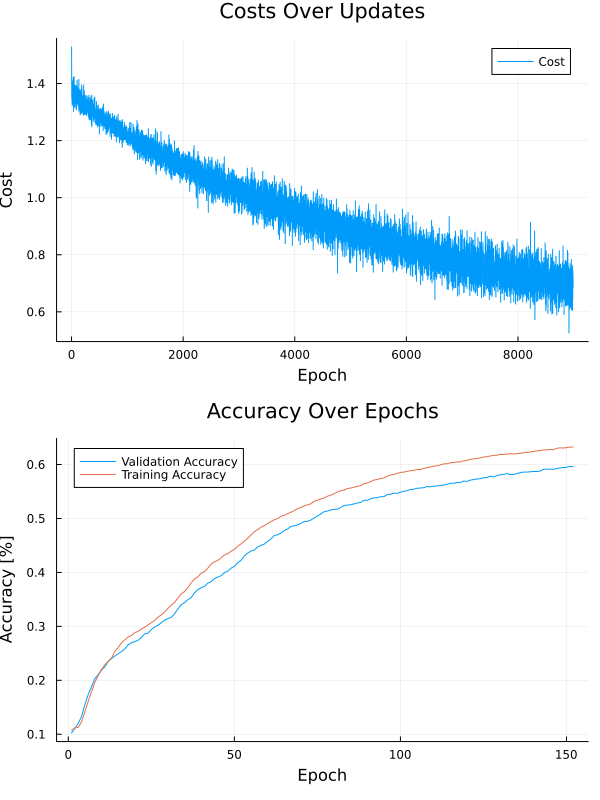

In [113]:
p_costs = plot(costs, title="Costs Over Updates", label="Cost", xlabel="Epoch", ylabel="Cost")
p_accuracy = plot(accuracies, title="Accuracy Over Epochs", label="Validation Accuracy", xlabel="Epoch", ylabel="Accuracy [%]")
plot!(p_accuracy, train_accuracies, label="Training Accuracy")

combined_plot = plot(p_costs, p_accuracy, layout=(2, 1), size=(600, 800))
savefig(combined_plot, "combined_plot.png")
display(combined_plot)

0.43965772929699287


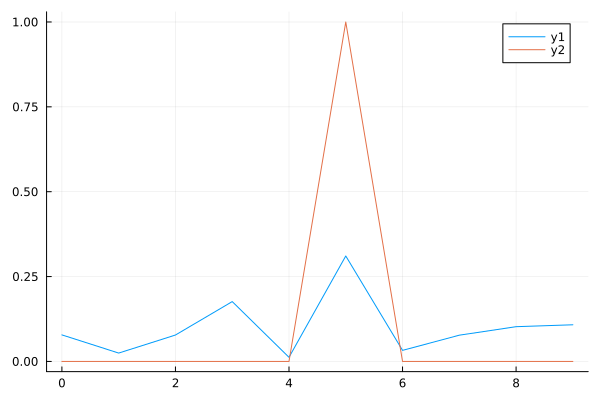

In [127]:
randnum = rand(1:batch_size)
feature = feature_batches[1][randnum,:] 
label = label_batches[1][randnum,:]

# forward pass
z1 = W1 * feature + B1
a1 = activ1(z1) 

z2 = W2 * a1 + B2
a2 = activ2(z2)

z3 = W3 * a2
output = activ3(z3)

# loss function
loss = cross_entropy_loss(output, label)
loss_derivative = cross_entropy_loss_derivative(output, label)

# backpropagation_pass
delta_3 = activ_der3(loss_derivative)
delta_2 = activ_der2(transpose(W3) * delta_3)
delta_1 = activ_der1(transpose(W2) * delta_2)

grad3 = delta_3 * transpose(a2)
grad2 = delta_2 * transpose(a1)
grad1 = delta_1 * transpose(feature)

    # bias derivative of cost function equals delta * 1
grad_bias3 = delta_3
grad_bias2 = delta_2
grad_bias1 = delta_1




println(loss)
plot([0,1,2,3,4,5,6,7,8,9], output)
plot!([0,1,2,3,4,5,6,7,8,9], label)